## Protocol Analysis

It would probably be good to make these actual python libraries. Oh well.

In [1]:
# First extract logs with "PERF" from the client/receiver logs

from pathlib import Path

filename="04_09/test.out"

if not Path(filename).exists():
    !cat ../logs/replica*.log ../logs/client*.log | grep PERF >{filename}

In [2]:
# Basic log parsing

import re
import datetime 

def parse_time(line):
    match = re.search(f"([0-9]*:[0-9]*:[0-9]*.[0-9]*)", line)
    time_str = match.group(1);
    return datetime.datetime.strptime(time_str, "%H:%M:%S.%f")

def parse_tags(line):
    tags = {}
    line = line.split("PERF ")[1]
    for token in line.split():
        [tag, value] = token.split("=")
        tags[tag] = value
        try:
            tags[tag] = int(value)
        except ValueError as verr:
            pass
            
    return tags
        
def parse_line(line):
    time = parse_time(line)
    tags = parse_tags(line)

    tags["time"] = time
    return tags 

In [3]:
all_events = []

with open(filename) as f:
    for line in f:
        try:
            all_events.append(parse_line(line))
        except:
            pass

all_events = sorted(all_events, key=lambda x: x['time'])
all_commits = list(filter(lambda x: x["event"] == "commit", all_events))

In [4]:
# Look at each client commit, make sure there are no two clients ops on the same seq
from collections import Counter

# counts = Counter(c["seq"] for c in all_commits if c["path"] != "missed")
# for seq in counts:
#     if counts[seq] > 1:
#         print(f"Sequence {seq} has different commits!")
#         print(list(
#             f"c_id={x['client_id']} c_seq={x['client_seq']} path={x['path']} round={x['round']}" 
#            for x in filter(lambda x: x["seq"] == seq, all_commits)
#         ))

In [5]:
# Ensure all client operations are committed
clients = set(x['client_id'] for x in all_commits)

# for c_id in clients:
#     c_commits = filter(lambda x: x["client_id"] == c_id, all_commits)
#     seq = sorted(c["client_seq"] for c in c_commits)

#     for x, y in zip(seq, seq[1:]):
#         if (y-x) > 1:
#             print(f"Client {c_id} missed commits between {x + 1}-{y - 1}")
        
#         if x == y:
#             print(f"Client {c_id} repeated commits {x}")


In [6]:

start_time = all_events[0]['time'] + datetime.timedelta(seconds=10)
end_time = all_events[-1]['time'] - datetime.timedelta(seconds=10)

events = list(filter(lambda x: x['time'] > start_time and x['time'] < end_time, all_events))
commits = list(filter(lambda x: x["event"] == "commit", events))

In [7]:
# Get general stats
import numpy as np



runtime = (commits[-1]["time"] - start_time).total_seconds()
print(f"Runtime: {runtime:.3f} s")
print(f"Total Throughput: {len(commits) / runtime:.2f} req/s")

latencies = np.array([c['latency'] for c in commits])
print(f"Num commits: {len(commits)}")
print(f"Average latency: {np.mean(latencies):.0f} us")
print(f"p95 latency: {np.percentile(latencies, 95):.0f} us")
print(f"p99 latency: {np.percentile(latencies, 99):.0f} us")

fast = list(filter(lambda x: x["path"] == "fast", commits))
normal = list(filter(lambda x: x["path"] == "normal", commits))
slow = list(filter(lambda x: x["path"] == "slow", commits))
missed = list(filter(lambda x: x["path"] == "missed", commits))

print("Fast path:")
print(f"\tNum commits: {len(fast)}")
if len(fast) > 0:
    print(f"\tAverage latency: {sum(c['latency'] for c in fast) / len(fast):.0f} us")


print("Normal path:")
print(f"\tNum commits: {len(normal)}")
if len(normal) > 0:
    print(f"\tAverage latency: {sum(c['latency'] for c in normal) / len(normal):.0f} us")

print("Slow path:")
print(f"\tNum commits: {len(slow)}")
if len(slow) > 0:
    print(f"\tAverage latency: {sum(c['latency'] for c in slow) / len(slow):.0f} us")

print("Missed path:")
print(f"\tNum commits: {len(missed)}")
if len(missed) > 0:
    print(f"\tAverage latency: {sum(c['latency'] for c in missed) / len(missed):.0f} us")


Runtime: 29.353 s
Total Throughput: 12118.90 req/s
Num commits: 355731
Average latency: 171092 us
p95 latency: 724142 us
p99 latency: 1495464 us
Fast path:
	Num commits: 324556
	Average latency: 136864 us
Normal path:
	Num commits: 21824
	Average latency: 210431 us
Slow path:
	Num commits: 7585
	Average latency: 673366 us
Missed path:
	Num commits: 1766
	Average latency: 3817990 us


In [19]:
# Get the throughput over periods of 100ms every 10ms  

commits = [x for x in commits if x["client_id"] == 0]

import numpy as np

w_size = 0.5 #s
resolution = 0.1 #s

end = (commits[-1]["time"] - start_time).total_seconds()

for c in commits:
     c["t"] = (c["time"] - start_time).total_seconds()

w_start = 0
i = 0
j = 0

commit_counts = []
commit_paths = []

while w_start + w_size < end:
    while (commits[i]["t"] < w_start):
        i += 1
    while (commits[j]["t"] <= w_start + w_size):
        j += 1

    commit_counts.append(j - i)

    if (j > i):
        path_counts = Counter(c["path"] for c in commits[i:j])
        commit_paths.append(path_counts.most_common(1)[0][0])
    else:
        commit_paths.append("slow")
    
    w_start += resolution


times = np.arange(0, end - w_size, resolution)
throughput = np.array(commit_counts) / w_size

def pathToColor(path):
    if path == "fast": return 'g'
    elif path == "normal": return 'b'
    elif path == "slow": return 'r'
    else: return 'grey'

colors=[ pathToColor(path) for path in commit_paths ]

In [20]:
# Get first fallback start time for each instance

fallback_starts = list(filter(lambda x: x["event"] == "repair_start" and x["replica_id"] == 0, events))

fallback_starts_t = [
    (x["time"] - start_time).total_seconds()
    for x in fallback_starts
]

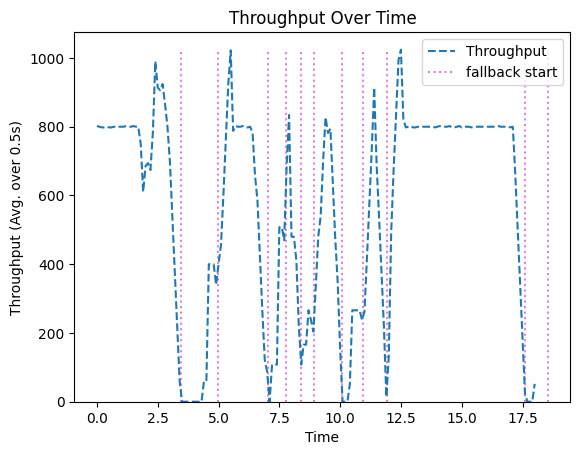

In [21]:
# Plot throughput over time
import matplotlib.pyplot as plt


plt.plot(times, throughput, label='Throughput', linestyle="--")
plt.vlines(fallback_starts_t, min(throughput), max(throughput), color='m', linestyle='dotted', label='fallback start', alpha=0.5)

plt.title('Throughput Over Time')
plt.xlabel('Time')
plt.ylabel(f'Throughput (Avg. over {w_size}s)')
plt.legend()

plt.ylim(0, None)
plt.show()

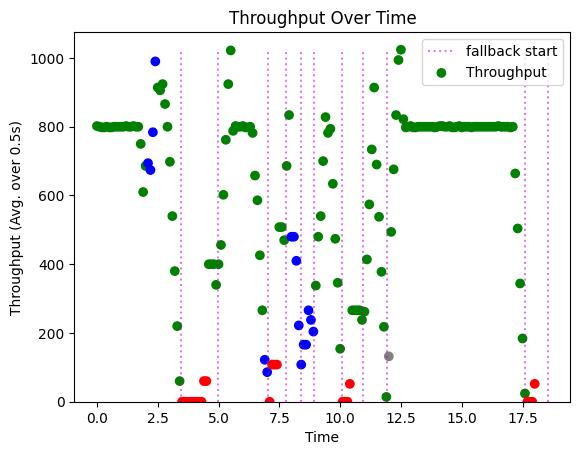

In [22]:
# Same graph, but with indications of which type of commit was done
plt.vlines(fallback_starts_t, min(throughput), max(throughput), color='m', linestyle='dotted', label='fallback start', alpha=0.5)
plt.scatter(times, throughput, label='Throughput', alpha=1, c=colors)


plt.title('Throughput Over Time')
plt.xlabel('Time')
plt.ylabel(f'Throughput (Avg. over {w_size}s)')
plt.legend()
plt.ylim(0, None)
plt.show()

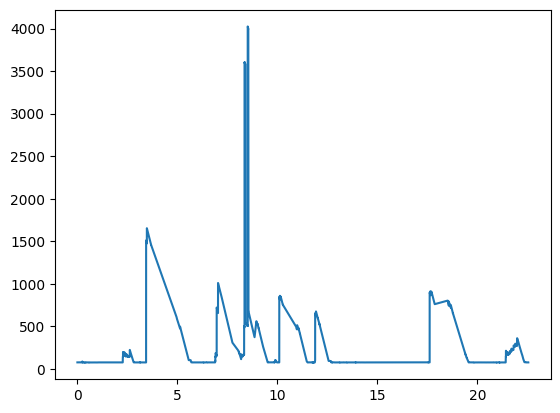

In [12]:
cs = [x for x in commits if x["client_id"] == 4]

start_times = [x["time"].timestamp() - x["latency"] / 10**6 for x in cs]
min_t = min(start_times)

starts = [t - min_t for t in start_times] 

data = list(zip(starts, cs))
data = sorted(data, key=lambda t: t[0])

latencies = [(t, x["latency"] / 1000) for t, x in data]

times, latencies = zip(*latencies)

plt.plot(times, latencies)


In [13]:
min((x for x in latencies))

75.063

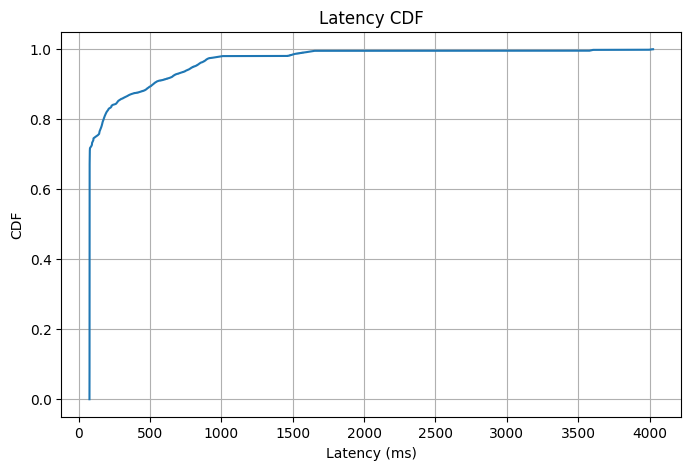

In [14]:
# Sort the data
latencies_sorted = np.sort(latencies)

# Calculate the CDF values
cdf = np.arange(1, len(latencies_sorted) + 1) / len(latencies_sorted)

# Plot

plt.figure(figsize=(8, 5))
plt.plot(latencies_sorted, cdf)
plt.title('Latency CDF')
plt.xlabel('Latency (ms)')
plt.ylabel('CDF')
plt.grid(True)
plt.show()